## Part 1: Source historic transaction and price data for BUBBLE/wETH on UniswapV3 for one day 
### task done via the web3 notebook. results have stored to avoid re reunning the script. requires API access from your chosen provider 


## Part 2: Source historic transaction and price data for SPOT BUBBLE/USDT from HTX (https://www.htx.com/) for the period chosen in Part 1.
done via cctx package + limitation trick (see code  below)

In [19]:
#%pip install ccxt
#%pip install python-scipy
import ccxt
import sys


# Set Up The Chart Drawing

In [20]:
# Enables 2x resolution for Retina displays
%config InlineBackend.figure_format = 'retina'

# This is the library we will use for chart drawing
import matplotlib.pyplot as plt

# Configure the look
#plt.style.use ('seaborn-white')
#plt.rcParams["figure.figsize"] = [15,6]

# Load HUOBI token avalaible

In [21]:
# Load Huobi and check if BUBBLE is there
huobi = ccxt.huobi()
huobi.load_markets ()

print ('huobi: %d markets loaded!' % len (huobi.markets))

huobi: 2048 markets loaded!


#  BUBBLE  traded vs USDT where UNISWAP  used ETH as REF  prices. this requires conversion

In [22]:
import pandas as pd
from datetime import datetime


startDate = "2024-12-20"
startDate = datetime.strptime(startDate, "%Y-%m-%d")
startDate = datetime.timestamp(startDate)
startDate = int(startDate) * 1000

startDate

1734638400000

### Test CCTX to sanity proce check

In [23]:



LIMIT= 3000
#print(startDate)  #output: 1589846400000


pair = 'BUBBLE/USDT'

# Load OHLCV (open/high/low/close/volume) data with 1-min resolution
ohlcv = huobi.fetch_ohlcv (pair, '1m', since= startDate, limit=LIMIT)



In [24]:
from_ts = startDate
ohlcv_list = []
ohlcv = huobi.fetch_ohlcv('BUBBLE/USDT', '1m', since=from_ts, limit=1000)
ohlcv_list.append(ohlcv)
while True:
    from_ts = ohlcv[-1][0]
    new_ohlcv = huobi.fetch_ohlcv('BUBBLE/USDT', '1m', since=from_ts, limit=1000)
    ohlcv.extend(new_ohlcv)
    if len(new_ohlcv)!=1000:
    	break

In [25]:
# Get closing prices for each day
prices = [x[4] for x in ohlcv]

# Convert Unix timestamps to Python dates
dates = [datetime.fromtimestamp (x[0] // 1000) for x in ohlcv]

# Prepare a Pandas series object
data = pd.Series (prices, index=dates)
# Draw a simple line chart
data['open']=[x[1] for x in ohlcv]
data['high']=[x[2] for x in ohlcv]
data['low']=[x[3] for x in ohlcv]
data['close']=[x[4] for x in ohlcv]
data['volume']=[x[5] for x in ohlcv]

### NIce graph

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

candlesticks = go.Candlestick(
    x=data.index,
    open=data['open'],
    high=data['high'],
    low=data['low'],
    close=data['close'],
    showlegend=False,

)

volume_bars = go.Bar(
    x=data.index,
    y=data['volume'],
    showlegend=False,
    marker={
        "color": "rgba(128,128,128,0.5)",
    }
)

fig = go.Figure(candlesticks)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(candlesticks, secondary_y=True)
fig.add_trace(volume_bars, secondary_y=False)
fig.update_layout(
    title="BUBBLE/USDT pool price data as os 20 Dec from CEX HUOBI",
    height=800,
    # Hide Plotly scrolling minimap below the price chart
    xaxis={"rangeslider": {"visible": False}},
)
fig.update_yaxes(title="Price BUBBLE/USDT", secondary_y=True, showgrid=True)
fig.update_yaxes(title="Volume BUBBLE/USDT", secondary_y=False, showgrid=False)
fig.show()

### Now that we 'e confortable with want to obtain we download the ETH/USDT and BUBBLE/USDT  historical price  (period 20 Dec - 28 Dec, frequence minute)

In [27]:

pair_BubbleUSDT = 'BUBBLE/USDT'
pair_ETHUSDT = 'ETH/USDT'


# Load OHLCV (open/high/low/close/volume) data with 1-min resolution
#huobi_BubbleUSDT_ohlcv = huobi.fetch_ohlcv (pair_BubbleUSDT, '1m', since=startDate, limit=LIMIT)
#huobi_ETHUSDT_ohlcv = huobi.fetch_ohlcv (pair_ETHUSDT, '1m', since=startDate, limit=LIMIT)






def Get_historicaldata(symbol='BUBBLE/USDT', timeframe='1m', from_ts=startDate):
    '''
    circumvent CCTX restriction of number of data fetchper per call
    Symbol : ticker to download
    timeframe : 1m
    '''
    ohlcv_list = []
    ohlcv = huobi.fetch_ohlcv(symbol, timeframe, since=from_ts, limit=1000)
    ohlcv_list.extend(ohlcv)  # Changed from append to extend for the initial data
    
    while True:
        from_ts = ohlcv_list[-1][0]  # Use the last timestamp from ohlcv_list
        new_ohlcv = huobi.fetch_ohlcv(symbol, timeframe, since=from_ts, limit=1000)  # Added timeframe parameter
        ohlcv_list.extend(new_ohlcv)  # Extend ohlcv_list instead of ohlcv
        
        if len(new_ohlcv) != 1000:
            break
            
    return ohlcv_list


huobi_BubbleUSDT_ohlcv=Get_historicaldata(pair_BubbleUSDT)
huobi_ETHUSDT_ohlcv = Get_historicaldata(pair_ETHUSDT)


In [28]:

# Get closing prices for each token
pricesBubbleUSDT = [x[4] for x in huobi_BubbleUSDT_ohlcv ]
pricesETHUSDT = [x[4] for x in huobi_ETHUSDT_ohlcv ]

# get open price for conversion
openBubbleUSDT = [x[1] for x in huobi_BubbleUSDT_ohlcv ]
openETHUSDT = [x[1] for x in huobi_ETHUSDT_ohlcv ]

### convert BUBBLE historical price from CEX in ETH  so we can compare with data get from uniswap

In [29]:
close=[]# prices in eth

for n1, n2 in zip(pricesBubbleUSDT,pricesETHUSDT):
        if n2 == 0:
            raise ValueError(f"Division by zero encountered: {n1}/{n2}")
        close.append(n1/n2)

In [30]:





open=[] 
for n1, n2 in zip(openBubbleUSDT,openETHUSDT):
        if n2 == 0:
            raise ValueError(f"Division by zero encountered: {n1}/{n2}")
        open.append(n1/n2)
     

#Convert Unix timestamps to Python dates
dates = [datetime.fromtimestamp (x[0] // 1000) for x in huobi_ETHUSDT_ohlcv]

# Prepare a Pandas series object



# Draw a simple line chart


In [31]:
len(close)==len(openETHUSDT)

True

In [32]:


data = pd.DataFrame({
    'close': close,
    'open': open,
    'ETH_USDT' : openETHUSDT  # keeping eth price in USDT 
}, index=dates)



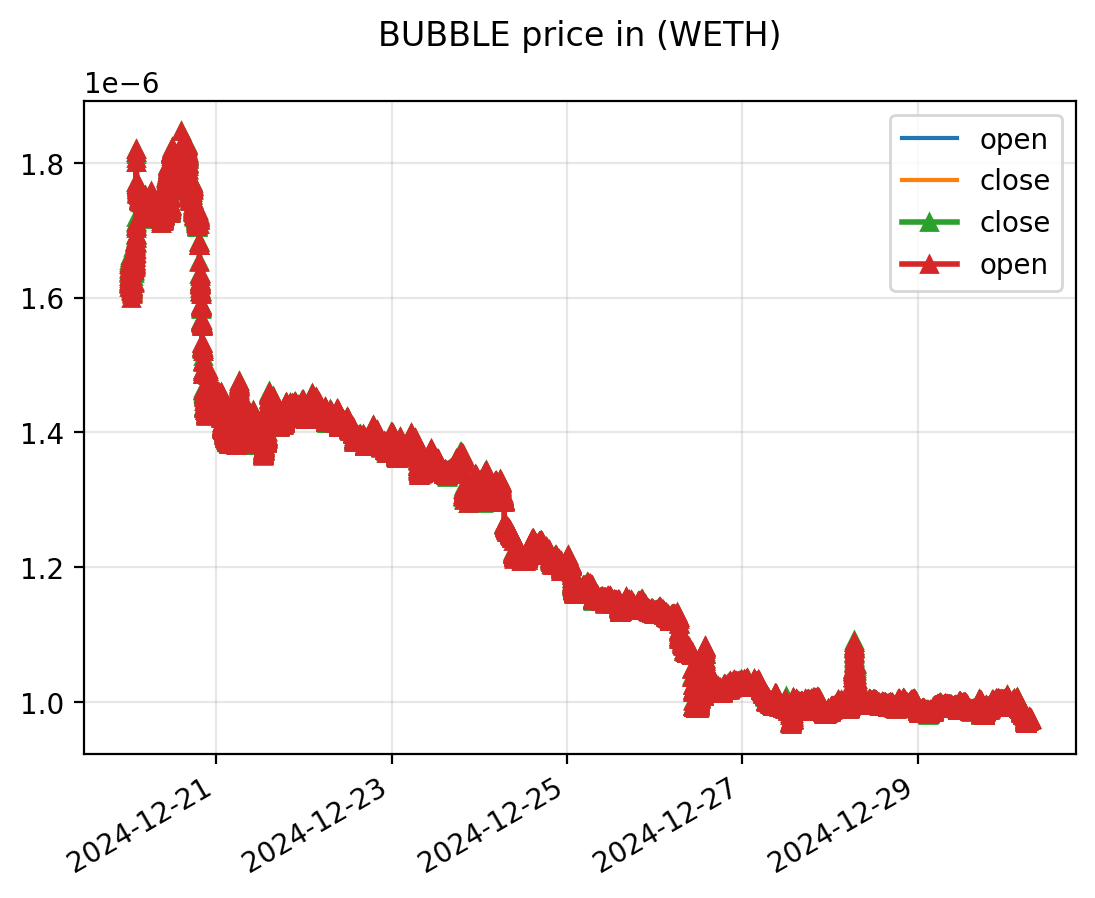

In [33]:
# test to compare CEX BUBBLE price vs ETH  and DEX BUBBLE price get from uniswap expressed in ETH

col =[i  for i in data.columns if i not in ("ETH_USDT")]
data[["open","close"]].plot()

for column in col:
   
    plt.plot(data.index, data[column], marker='^', linewidth=2, label=column)
plt.title('BUBBLE price in (WETH)', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)

##  Part 3: Compute the per minute theoretical CEX/DEX price discrepancy from the data in Part 1 & 2. to merge the two data sets and compute discrpancy: 
### basic data wrangling  mainly from UNISWAP data to get the OHLCV format : see web3 notebook 

In [34]:
## csv files containing Uniswap price to download

path="/home/faridb/Documents/dev/Python/ccxt/builtinfunc/BUBLE_WETH_UNISWAP_price.csv"

#df_Uniswap=pd.read_csv(path, index_col='timestamp',)


# For dates in format like "2023-12-31 23:59:59"
df_Uniswap = pd.read_csv(path, 
                 parse_dates=[0], 
                 index_col=0, 
                 date_format= '%Y-%m-%d %H:%M:%S')


data.columns.values[0] = 'close_CEX'
data.columns.values[1] = 'open_CEX'

df_Uniswap.head()


open      high       low     close    volume
timestamp                                                            
2024-12-20 20:28:00  0.000001  0.000001  0.000001  0.000001  0.000149
2024-12-20 20:29:00  0.000001  0.000001  0.000001  0.000001  0.000000
2024-12-20 20:30:00  0.000001  0.000001  0.000001  0.000001  0.000000
2024-12-20 20:31:00  0.000001  0.000001  0.000001  0.000001  0.000000
2024-12-20 20:32:00  0.000001  0.000001  0.000001  0.000001  0.000000

close_CEX_x  open_CEX_x  ETH_USDT      open      high  \
2024-12-20 20:28:00     0.000001    0.000001   3392.32  0.000001  0.000001   
2024-12-20 20:29:00     0.000001    0.000001   3389.60  0.000001  0.000001   
2024-12-20 20:30:00     0.000001    0.000001   3388.61  0.000001  0.000001   
2024-12-20 20:31:00     0.000001    0.000001   3391.21  0.000001  0.000001   
2024-12-20 20:32:00     0.000001    0.000001   3387.18  0.000001  0.000001   

                          low     close    volume  
2024-12-20 20:28:00  0.000001  0.000001  0.000149  
2024-12-20 20:29:00  0.000001  0.000001  0.000000  
2024-12-20 20:30:00  0.000001  0.000001  0.000000  
2024-12-20 20:31:00  0.000001  0.000001  0.000000  
2024-12-20 20:32:00  0.000001  0.000001  0.000000

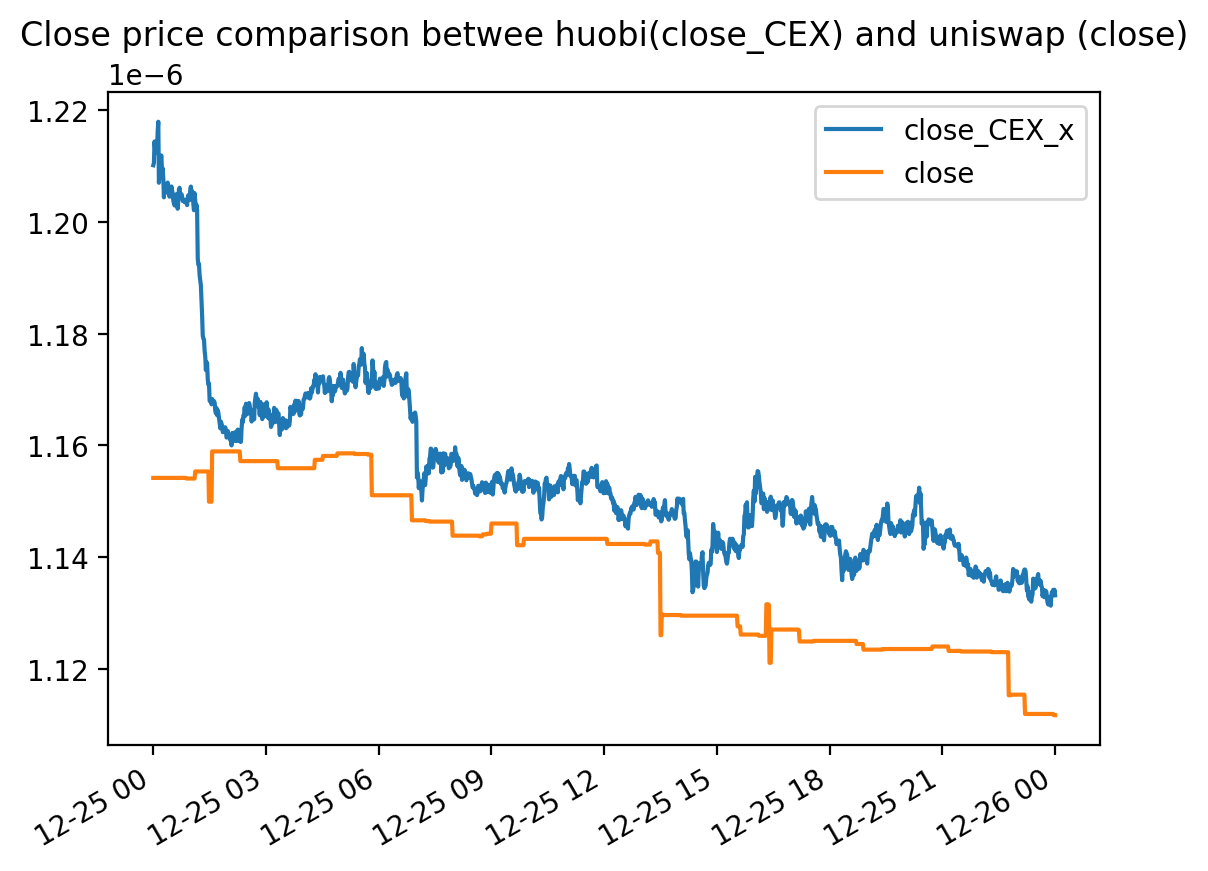

In [35]:

# merge df_uniswap with cex_data & column name adjustment


df_merge=pd.merge(data, df_Uniswap, left_index=True, right_index=True)
interval = df_merge.index.to_series().between('2024-12-25', '2024-12-26')

#df_merge[['close_CEX_x','close']][interval].plot.scatter(x='close_CEX_x',y='close', c='DarkBlue')
df_merge[['close_CEX_x','close']][interval].plot( title="Close price comparison betwee huobi(close_CEX) and uniswap (close)")
df_merge.head()


### same as above but volume from Uniswap is added

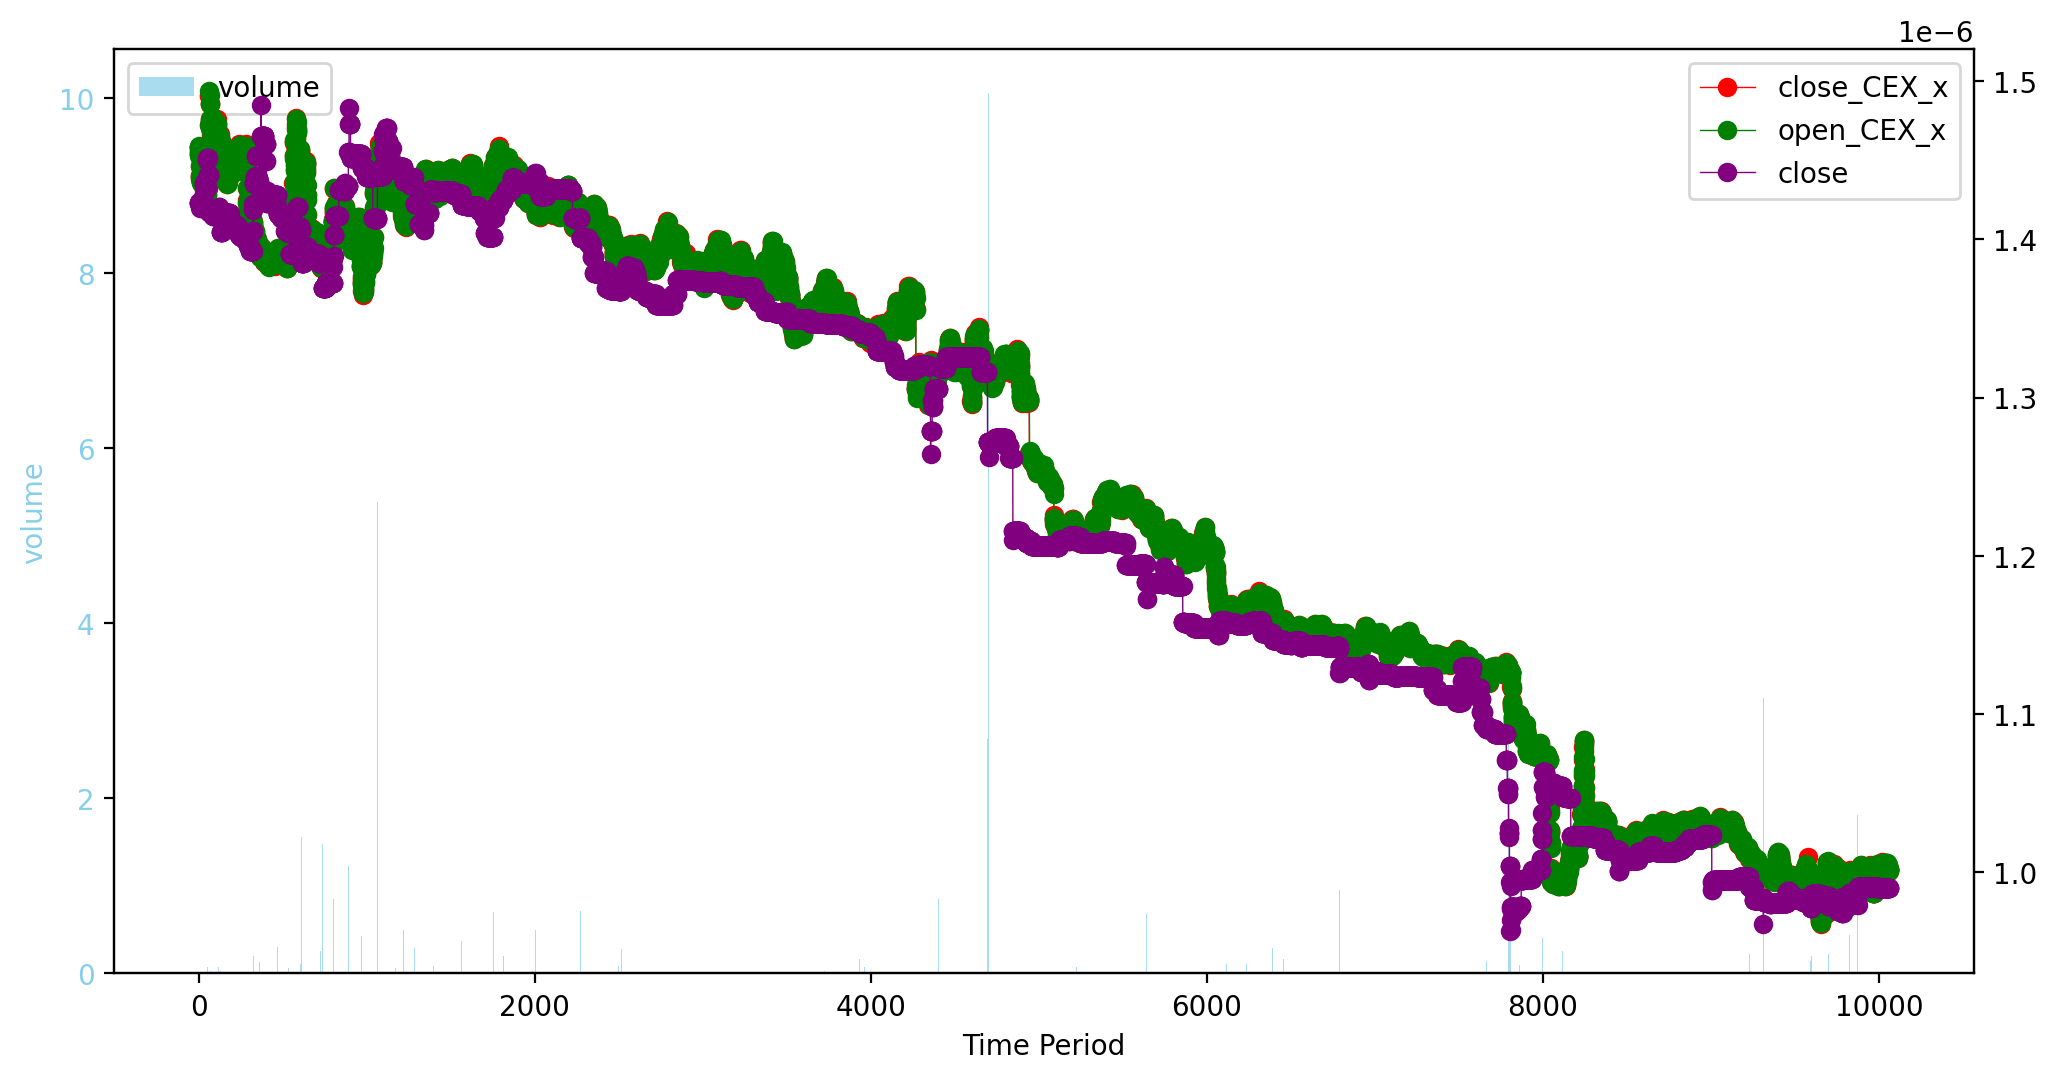

In [36]:



import numpy as np
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bars (first column after Date)
bar_column = 'volume'
x = range(len(df_merge))
bars = ax1.bar(x, df_merge[bar_column], color='skyblue', alpha=0.7)
ax1.set_xlabel('Time Period')
ax1.set_ylabel(bar_column, color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Set x-axis labels
#plt.xticks(x, df_merge.index, rotation=45) #['Date'].dt.strftime('%Y-%m'),

# Create second y-axis for lines
ax2 = ax1.twinx()

# Colors for different lines
colors = ['red', 'green', 'purple']

# Plot all other numeric columns as lines (except Date and bar_column)
line_columns = [col for col in df_merge.columns if col not in ['ETH_USDT','high','open', 'open_CEX_X','low',bar_column] and np.issubdtype(df_merge[col].dtype, np.number)]
lines = []
for i, column in enumerate(line_columns):
    color = colors[i % len(colors)]  # Cycle through colors if more lines than colors
    line = ax2.plot(x, df_merge[column], color=color, linewidth=0.5, 
                    marker='o', label=column)
    lines.extend(line)

# Add legend

ax1.legend(bars, [bar_column], loc='upper left')
ax2.legend(lines, line_columns, loc='upper right')


## First comment :Similar behavior with constant positive spread between DEX UNiswap price (close) and CEX price(HUOBI close). with CEX price behavior  seems to be lagging behind DEX. Some reasons could explained this : gas fees hampering arbitrage opportunities, low volume  relative to CEX, no possibility to monitor fee level within ETH network




In [37]:
df_merge 

close_CEX_x  open_CEX_x  ETH_USDT          open  \
2024-12-20 20:28:00     0.000001    0.000001   3392.32  1.422881e-06   
2024-12-20 20:29:00     0.000001    0.000001   3389.60  1.422881e-06   
2024-12-20 20:30:00     0.000001    0.000001   3388.61  1.422881e-06   
2024-12-20 20:31:00     0.000001    0.000001   3391.21  1.422881e-06   
2024-12-20 20:32:00     0.000001    0.000001   3387.18  1.422881e-06   
...                          ...         ...       ...           ...   
2024-12-27 19:55:00     0.000001    0.000001   3327.26  9.898537e-07   
2024-12-27 19:56:00     0.000001    0.000001   3325.32  9.898537e-07   
2024-12-27 19:57:00     0.000001    0.000001   3326.65  9.898537e-07   
2024-12-27 19:58:00     0.000001    0.000001   3326.07  9.898537e-07   
2024-12-27 19:59:00     0.000001    0.000001   3324.50  9.896557e-07   

                             high           low         close    volume  
2024-12-20 20:28:00  1.422881e-06  1.422881e-06  1.422881e-06  0.000149  
2024-12-20 20:29:00  1.422881e-06  1.422881e-06  1.422881e-06  0.000000  
2024-12-20 20:30:00  1.422881e-06  1.422881e-06  1.422881e-06  0.000000  
2024-12-20 20:31:00  1.422881e-06  1.422881e-06  1.422881e-06  0.000000  
2024-12-20 20:32:00  1.422881e-06  1.422881e-06  1.422881e-06  0.000000  
...                           ...           ...           ...       ...  
2024-12-27 19:55:00  9.898537e-07  9.898537e-07  9.898537e-07  0.000000  
2024-12-27 19:56:00  9.898537e-07  9.898537e-07  9.898537e-07  0.000000  
2024-12-27 19:57:00  9.898537e-07  9.898537e-07  9.898537e-07  0.000000  
2024-12-27 19:58:00  9.898537e-07  9.898537e-07  9.898537e-07  0.000000  
2024-12-27 19:59:00  9.896557e-07  9.896557e-07  9.896557e-07  0.006587  

[10062 rows x 8 columns]

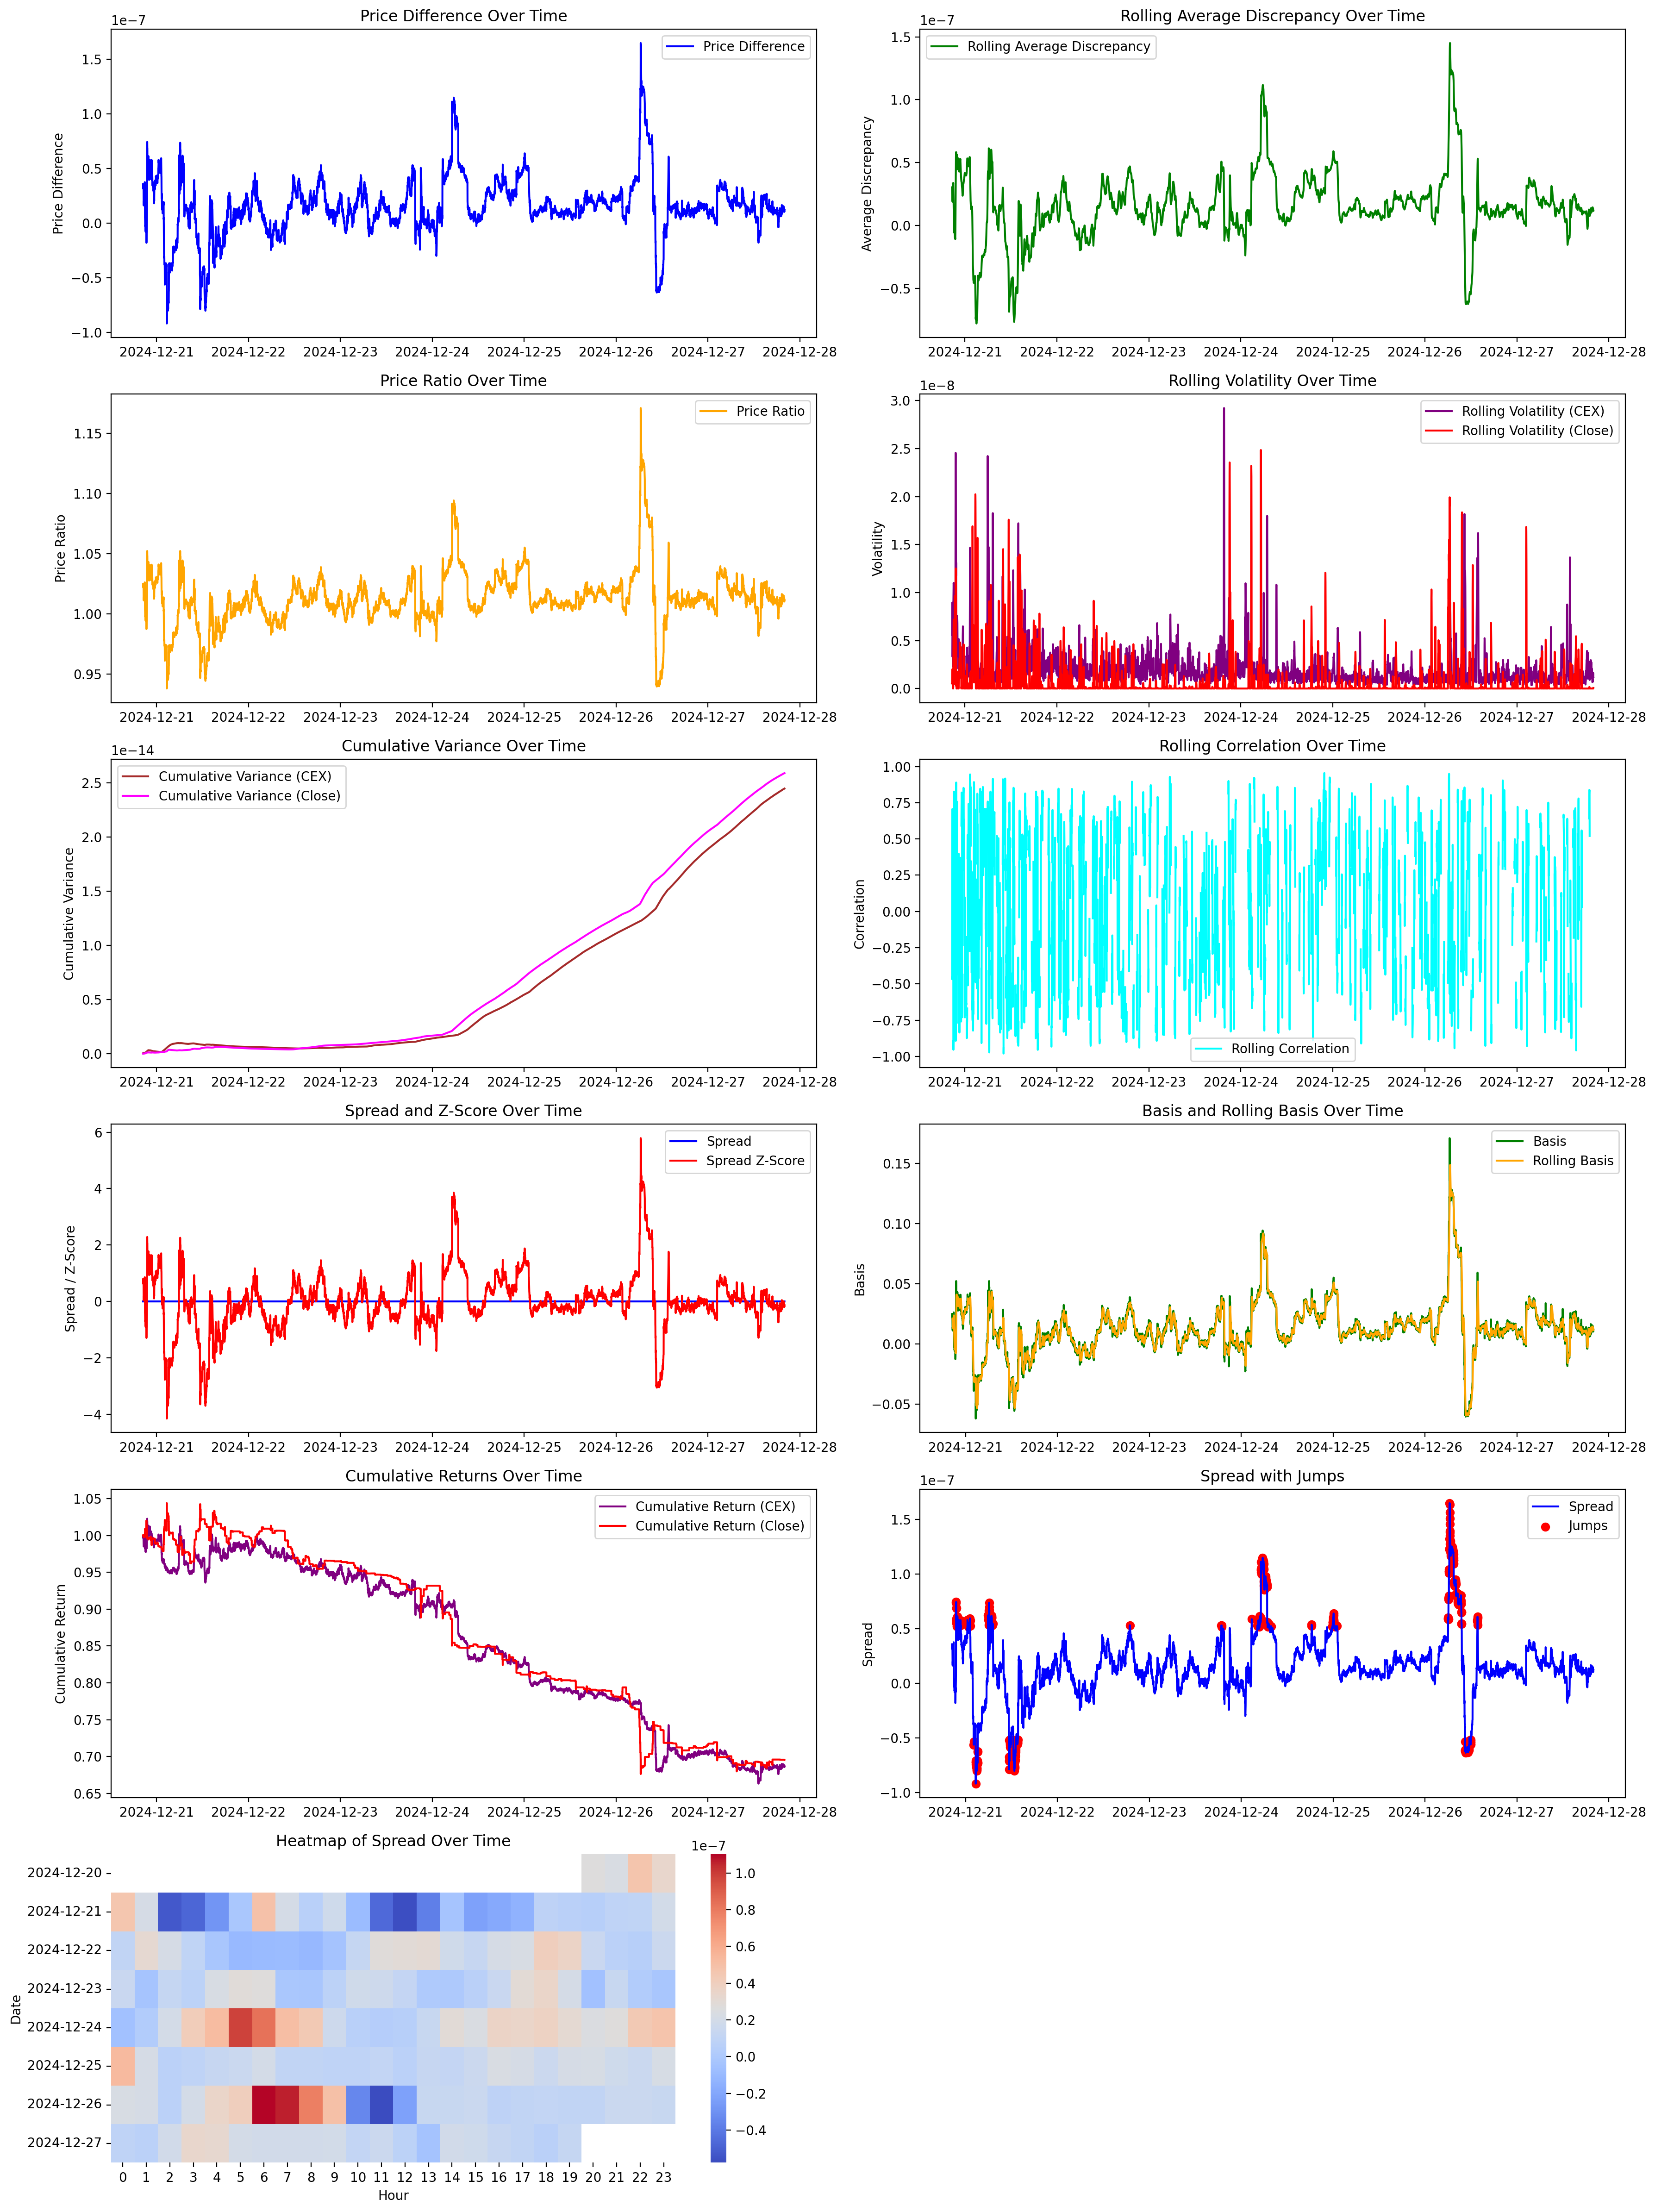

In [38]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



df_merge 
# Ensure the 'close_CEX_x' and 'close' columns are numeric
df_merge['close_CEX_x'] = pd.to_numeric(df_merge['close_CEX_x'])
df_merge['close'] = pd.to_numeric(df_merge['close'])

# Calculate metrics
df_merge['price_diff'] = df_merge['close_CEX_x'] - df_merge['close']
df_merge['rolling_avg_diff'] = df_merge['price_diff'].rolling(window=10).mean()
df_merge['price_ratio'] = df_merge['close_CEX_x'] / df_merge['close']
df_merge['rolling_volatility_CEX'] = df_merge['close_CEX_x'].rolling(window=10).std()
df_merge['rolling_volatility_close'] = df_merge['close'].rolling(window=10).std()
df_merge['cumulative_variance_CEX'] = df_merge['close_CEX_x'].expanding().var()
df_merge['cumulative_variance_close'] = df_merge['close'].expanding().var()
df_merge['rolling_correlation'] = df_merge['close_CEX_x'].rolling(window=10).corr(df_merge['close'])
df_merge['spread'] = df_merge['close_CEX_x'] - df_merge['close']
df_merge['spread_zscore'] = (df_merge['spread'] - df_merge['spread'].mean()) / df_merge['spread'].std()
df_merge['basis'] = (df_merge['close_CEX_x'] - df_merge['close']) / df_merge['close']
df_merge['rolling_basis'] = df_merge['basis'].rolling(window=10).mean()
df_merge['return_CEX'] = df_merge['close_CEX_x'].pct_change()
df_merge['return_close'] = df_merge['close'].pct_change()
df_merge['cumulative_return_CEX'] = (1 + df_merge['return_CEX']).cumprod()
df_merge['cumulative_return_close'] = (1 + df_merge['return_close']).cumprod()
df_merge['jump'] = np.where(abs(df_merge['spread']) > 2 * df_merge['spread'].std(), 1, 0)



# Plot the results
plt.figure(figsize=(18, 24))

# Price Difference
plt.subplot(6, 2, 1)
plt.plot(df_merge.index, df_merge['price_diff'], label='Price Difference', color='blue')
plt.title('Price Difference Over Time')
plt.ylabel('Price Difference')
plt.legend()

# Rolling Average Discrepancy
plt.subplot(6, 2, 2)
plt.plot(df_merge.index, df_merge['rolling_avg_diff'], label='Rolling Average Discrepancy', color='green')
plt.title('Rolling Average Discrepancy Over Time')
plt.ylabel('Average Discrepancy')
plt.legend()

# Price Ratio
plt.subplot(6, 2, 3)
plt.plot(df_merge.index, df_merge['price_ratio'], label='Price Ratio', color='orange')
plt.title('Price Ratio Over Time')
plt.ylabel('Price Ratio')
plt.legend()

# Rolling Volatility
plt.subplot(6, 2, 4)
plt.plot(df_merge.index, df_merge['rolling_volatility_CEX'], label='Rolling Volatility (CEX)', color='purple')
plt.plot(df_merge.index, df_merge['rolling_volatility_close'], label='Rolling Volatility (Close)', color='red')
plt.title('Rolling Volatility Over Time')
plt.ylabel('Volatility')
plt.legend()

# Cumulative Variance
plt.subplot(6, 2, 5)
plt.plot(df_merge.index, df_merge['cumulative_variance_CEX'], label='Cumulative Variance (CEX)', color='brown')
plt.plot(df_merge.index, df_merge['cumulative_variance_close'], label='Cumulative Variance (Close)', color='magenta')
plt.title('Cumulative Variance Over Time')
plt.ylabel('Cumulative Variance')
plt.legend()

# Rolling Correlation
plt.subplot(6, 2, 6)
plt.plot(df_merge.index, df_merge['rolling_correlation'], label='Rolling Correlation', color='cyan')
plt.title('Rolling Correlation Over Time')
plt.ylabel('Correlation')
plt.legend()

# Spread and Z-Score
plt.subplot(6, 2, 7)
plt.plot(df_merge.index, df_merge['spread'], label='Spread', color='blue')
plt.plot(df_merge.index, df_merge['spread_zscore'], label='Spread Z-Score', color='red')
plt.title('Spread and Z-Score Over Time')
plt.ylabel('Spread / Z-Score')
plt.legend()

# Basis and Rolling Basis
plt.subplot(6, 2, 8)
plt.plot(df_merge.index, df_merge['basis'], label='Basis', color='green')
plt.plot(df_merge.index, df_merge['rolling_basis'], label='Rolling Basis', color='orange')
plt.title('Basis and Rolling Basis Over Time')
plt.ylabel('Basis')
plt.legend()

# Cumulative Returns
plt.subplot(6, 2, 9)
plt.plot(df_merge.index, df_merge['cumulative_return_CEX'], label='Cumulative Return (CEX)', color='purple')
plt.plot(df_merge.index, df_merge['cumulative_return_close'], label='Cumulative Return (Close)', color='red')
plt.title('Cumulative Returns Over Time')
plt.ylabel('Cumulative Return')
plt.legend()

# Jump Detection
plt.subplot(6, 2, 10)
plt.plot(df_merge.index, df_merge['spread'], label='Spread', color='blue')
plt.scatter(df_merge.index[df_merge['jump'] == 1], df_merge['spread'][df_merge['jump'] == 1], color='red', label='Jumps')
plt.title('Spread with Jumps')
plt.ylabel('Spread')
plt.legend()

# Heatmap of Spread
plt.subplot(6, 2, 11)
pivot_table = df_merge.pivot_table(values='spread', index=df_merge.index.date, columns=df_merge.index.hour)
sns.heatmap(pivot_table, cmap='coolwarm')
plt.title('Heatmap of Spread Over Time')
plt.xlabel('Hour')
plt.ylabel('Date')

plt.tight_layout()
plt.show()

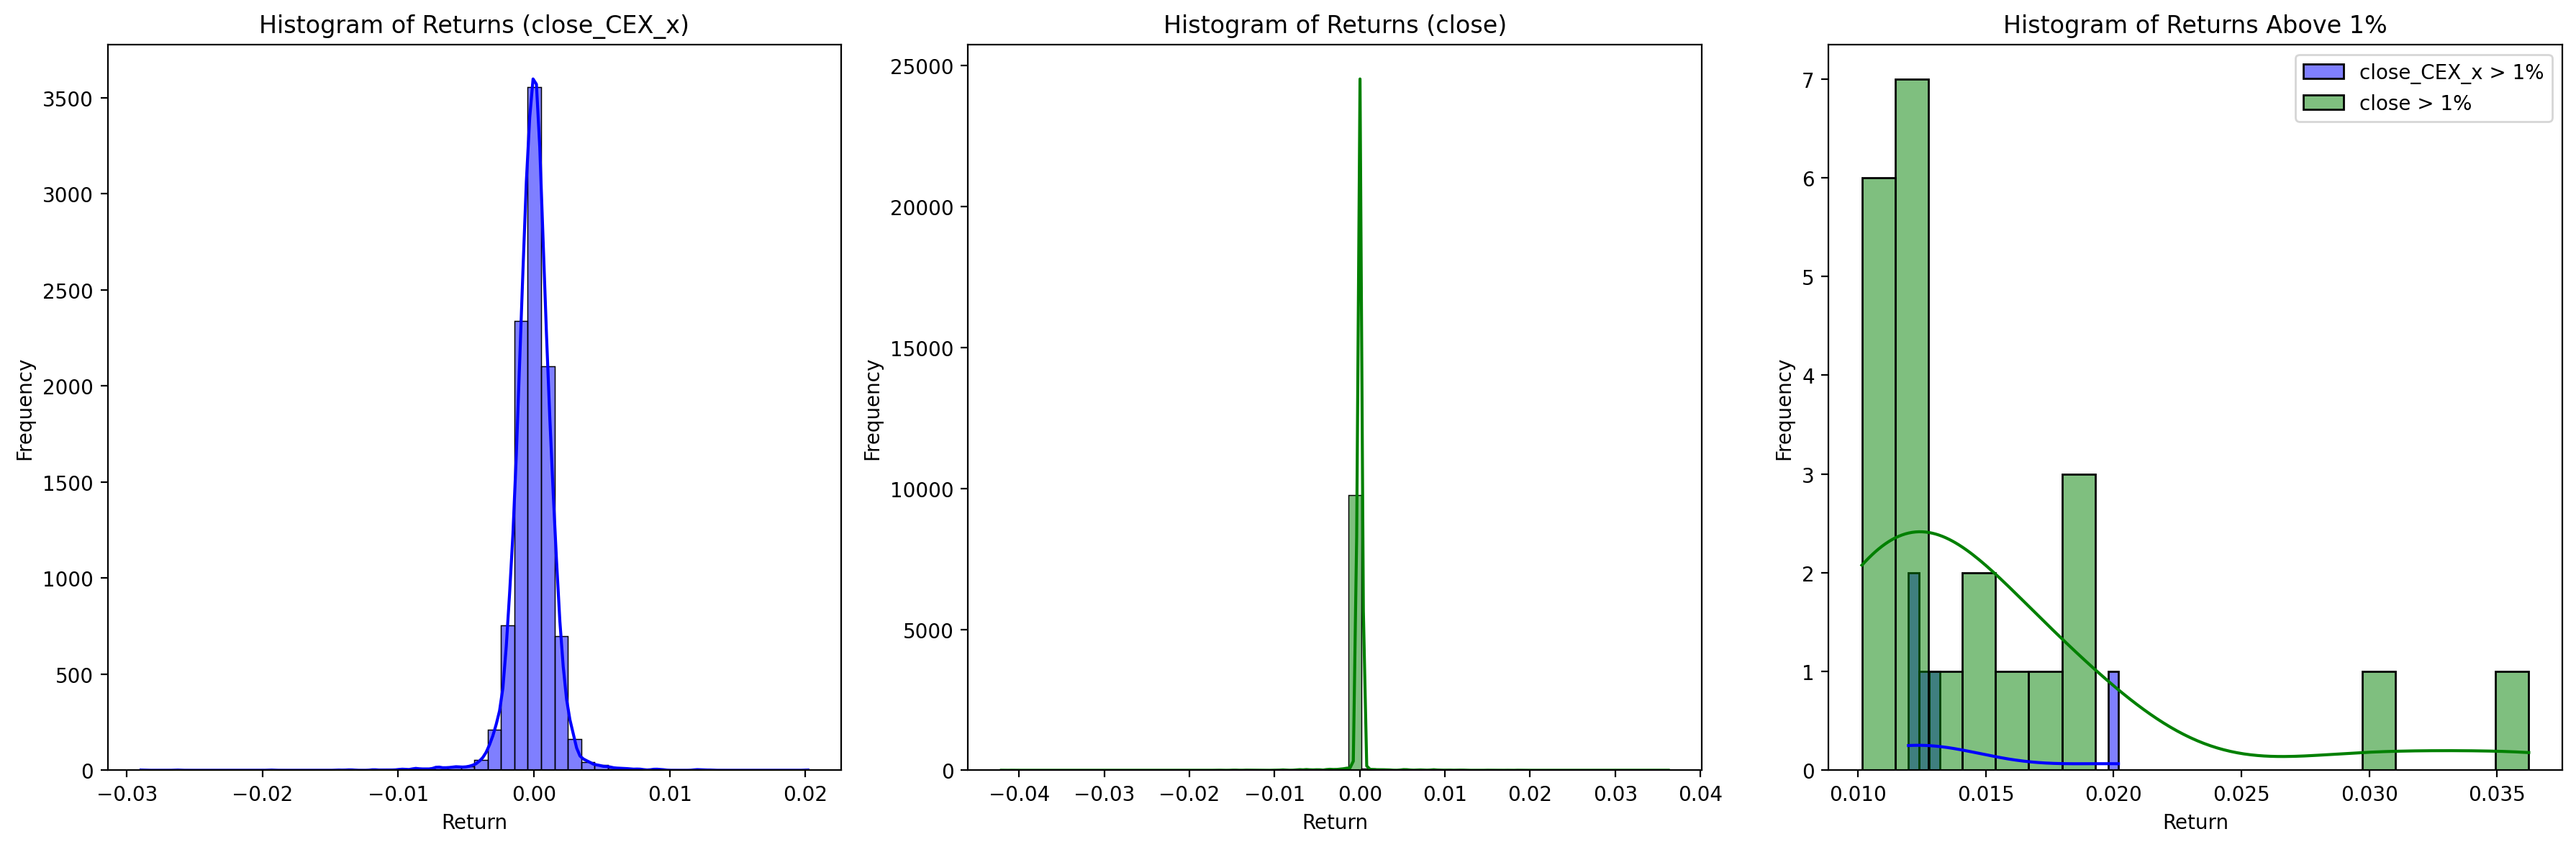

In [39]:

#histogram

# Ensure the 'close_CEX_x' and 'close' columns are numeric
df_merge['close_CEX_x'] = pd.to_numeric(df_merge['close_CEX_x'])
df_merge['close'] = pd.to_numeric(df_merge['close'])

# Calculate returns
df_merge['return_CEX'] = df_merge['close_CEX_x'].pct_change()
df_merge['return_close'] = df_merge['close'].pct_change()

# Filter returns above 1%
returns_CEX_above_1 = df_merge[df_merge['return_CEX'] > 0.01]['return_CEX']
returns_close_above_1 = df_merge[df_merge['return_close'] > 0.01]['return_close']

# Plot the histograms
plt.figure(figsize=(18, 6))

# Histogram of Returns for close_CEX_x
plt.subplot(1, 3, 1)
sns.histplot(df_merge['return_CEX'].dropna(), bins=50, kde=True, color='blue')
plt.title('Histogram of Returns (close_CEX_x)')
plt.xlabel('Return')
plt.ylabel('Frequency')

# Histogram of Returns for close
plt.subplot(1, 3, 2)
sns.histplot(df_merge['return_close'].dropna(), bins=50, kde=True, color='green')
plt.title('Histogram of Returns (close)')
plt.xlabel('Return')
plt.ylabel('Frequency')

# Histogram of Returns Above 1%
plt.subplot(1, 3, 3)
sns.histplot(returns_CEX_above_1, bins=20, kde=True, color='blue', label='close_CEX_x > 1%')
sns.histplot(returns_close_above_1, bins=20, kde=True, color='green', label='close > 1%')
plt.title('Histogram of Returns Above 1%')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

    Stalled Prices and Volatility:

        Stalled prices on the DEX (Decentralized Exchange) contribute to lower overall volatility compared to the CEX (Centralized Exchange). However, this also makes the DEX more sensitive to sudden price jumps. This phenomenon is primarily due to the Ethereum blockchain's structure and the low trading volume on the DEX.

    Significant Returns and Low Volume:

        The significant returns observed on the DEX are a direct consequence of its low trading volume. Since prices on the DEX are derived from observed transactions, even small trades can lead to large price movements. This contrasts with the CEX, where higher liquidity typically dampens the impact of individual trades.

    Price Jumps and CEX Behavior:

        When zooming in on the data, it becomes evident that large price jumps on the DEX have little to no impact on the return behavior of the CEX. This suggests that the two exchanges operate somewhat independently, with the CEX being less affected by the volatility and price anomalies observed on the DEX.

## # Part 4 : 
The persistent price difference between Uniswap and CEXs can be attributed to a combination of factors, including gas fees, low trading volume on Uniswap, Miner Extractable Value (MEV), differences in market structure, transaction speed, and arbitrage inefficiencies. While MEV can lead to temporary price discrepancies, the primary drivers are likely gas fees and low liquidity on Uniswap. These factors increase the cost of trading and slow down price adjustments compared to CEXs, where higher liquidity and faster transaction speeds facilitate more efficient price discovery.


# Part 5: 
## Strategy: we propose here a strategy that will aim to maximise the fee income for the LP by adjusting fee dynamically . This implies some assumptions that are considered at best constant (ETH price, gas fees, poll depth equal kappa, fees colected  is constant and proportional to the size trade, no action from protocol to prevent LVR,etc..) 

### we will simulate behavior of the strategy that will dynamicaly increase spread range  based on "risk" indicator. As only date with the OHLCV format  is available  order book here we will consider this below:

### ETH is the ref price (so is the volume)
#### Trades occurs when volume  is non negative
####  if price( time i) > price(time i-1) volume bid else volume ask
#### high/ low  column will be considered as bid/ask proxy to get a conservative
### we consider LP with  initial wealth x0, and an investment horizon [0;T] T>0 

# Part 5:  Strategy Overview:

We propose a strategy aimed at maximizing fee income for Liquidity Providers (LPs) by dynamically adjusting fees based on market conditions. This strategy relies on several simplifying assumptions to ensure tractability and focus on the core mechanics of fee optimization.

    Constant ETH Price: The price of ETH is assumed to remain constant throughout the simulation period.

    Fixed Gas Fees: Gas fees are considered constant, eliminating variability in transaction costs.

    Pool Depth (κ): The pool depth (κ) is assumed to remain constant, ensuring a stable liquidity environment.

    Fee Proportionality: Fees collected are assumed to be constant and directly proportional to the size of the trade.

    No Protocol Intervention: The protocol does not take any action to prevent Loss-Versus-Rebalancing (LVR) or other inefficiencies.

    OHLCV Data: Only OHLCV (Open, High, Low, Close, Volume) data is available, and the order book is not directly observable.

Simulation Framework:
Key Considerations:

    ETH as Reference Price: ETH is used as the reference price, and volume is denominated in ETH.

    Trade Execution: Trades are assumed to occur only when the volume is non-negative.

        If the price at time ii is greater than the price at time i−1i−1, the volume is considered as bid volume.

        If the price at time ii is less than the price at time i−1i−1, the volume is considered as ask volume.

    Bid/Ask Proxy: The High and Low columns in the OHLCV data are used as proxies for bid and ask prices, providing a conservative estimate of the spread.

    LP Initial Wealth: The LP starts with an initial wealth of x0x0​.

    Investment Horizon: The strategy is simulated over a finite investment horizon [0,T][0,T], where T>0T>0.

Strategy Mechanics:

The strategy dynamically adjusts the spread range based on a "risk" indicator derived from market conditions. By widening the spread during periods of higher perceived risk, the LP can capture higher fees while mitigating potential losses. Conversely, during periods of lower risk, the spread is narrowed to attract more trading volume and maximize fee income.

Rationale:

    Volatility-Based Spread: By linking the spread to observed volatility, the strategy balances risk and reward, ensuring that the LP is adequately compensated for market uncertainty.

    Fee Escalation in Low Volatility: The gradual increase in fees during low-volatility periods helps maintain fee income despite reduced trading activity.

    Responsive Reset Mechanism: Resetting fees after each trade ensures that the strategy remains adaptive and aligned with real-time market conditions.

Simulation Goals:

    Fee Maximization: Evaluate the strategy's ability to maximize fee income for the LP over the investment horizon.

    Risk Management: Assess the effectiveness of the dynamic spread adjustment in managing risk and reducing exposure to adverse price movements.

    Performance Comparison: Compare the performance of the dynamic fee strategy against a static fee strategy to quantify the benefits of dynamic adjustment.



Strategy Overview:

The proposed strategy relies on a dynamic spread adjustment mechanism, where the spread is computed based on observed volatility. This volatility is directly reflected in the adjusted fees. Additionally, due to the low volatility environment, the strategy incorporates a gradual increase in fees over time. These fees are reset after each new trade to ensure responsiveness to changing market conditions.

  0%|          | 1/10062 [00:00<20:49,  8.05it/s]

100%|██████████| 10062/10062 [00:00<00:00, 11547.13it/s]


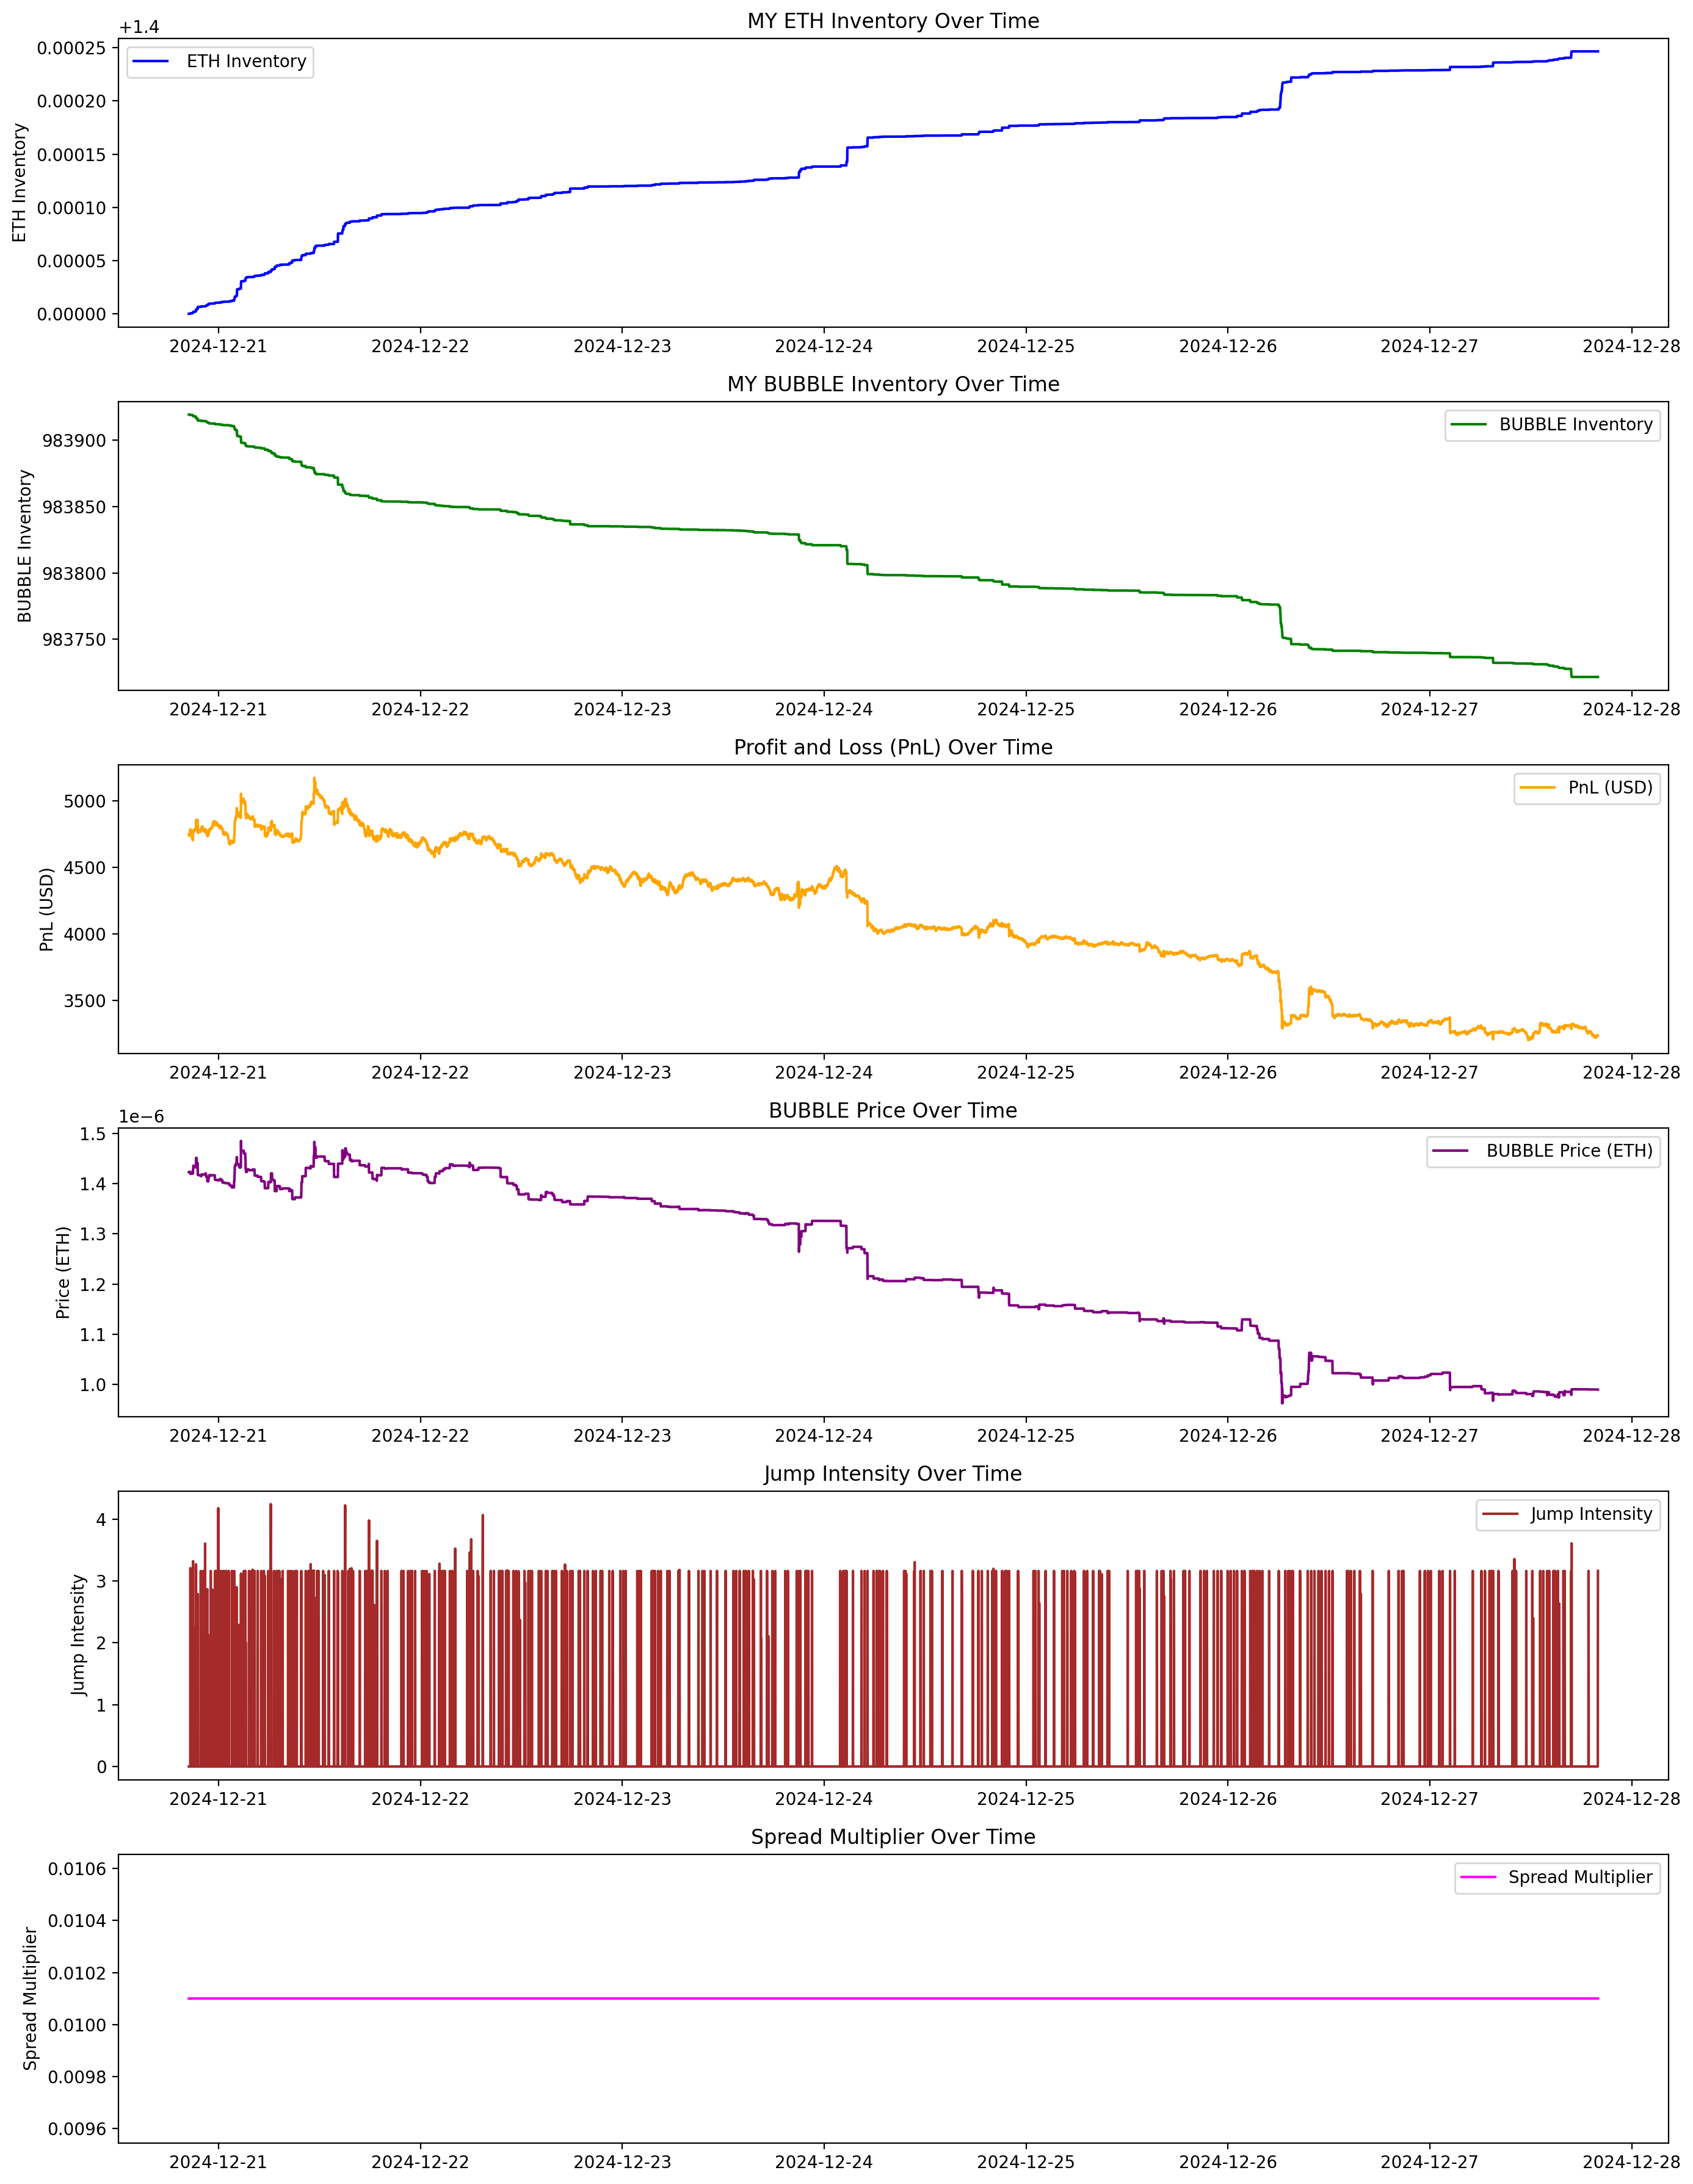

Final ETH Inventory: 1.400246668221479
Final BUBBLE Inventory: 983721.6276384088
Final PnL (ETH): 0.9737923998029236
Final PnL (USD): 3237.3728331448197


In [ ]:
# Load the data
df_merge 

# Initialize variables
pool_eth = 14  # Total ETH in the pool this roughly is the value of the pool at the time the exerecise is run
Z = df_merge.iloc[0]['close']  # Price of BUBBLE in ETH (Z)
pool_bubble = pool_eth / Z  # Total BUBBLE in the pool (14 / Z) 
pool_depth_k = pool_eth * pool_bubble  # Initial pool depth K

# Your ownership
ownership_percentage = 1.  # 10% ownership
my_eth = 1.4  # Your ETH contribution (1.4 ETH)
my_bubble = my_eth / Z  # Your BUBBLE contribution (1.4 / Z)

# Market-making variables
cashflow = 0  # Cumulative cash flow
initial_spread_multiplier = 0.01  # Initial spread as a percentage of the mid-price
spread_growth_rate = 0.0001  # Rate at which the spread multiplier increases over time
inventory_target = 0  # Target inventory level
inventory_tolerance = 10  # Tolerance for inventory deviation
max_inventory = 20  # Maximum allowed inventory imbalance
tick_size = 0.0001  # Minimum price movement (tick size)
jump_threshold_multiplier = 2  # Multiplier for detecting jumps (e.g., 2x rolling volatility)
discrepancy_spread_component = 0  # Component of spread due to price discrepancy

# Arrays to store results
bid_prices = []
ask_prices = []
eth_inventories = []
bubble_inventories = []
cashflows = []
pnl_eth = []  # Profit and Loss in ETH
pnl_usd = []  # Profit and Loss in USD
prices = []  # Mid-price over time
price_differences = []  # Price difference between exchanges
jump_intensities = []  # Jump intensity over time
spread_multipliers = []  # Spread multiplier over time
discrepancy_spread_components = []  # Discrepancy spread component over time

# Function to calculate rolling volatility
def calculate_rolling_volatility(data, window=10):
    return data['close'].rolling(window=window).std()

# Function to calculate rolling average price difference
def calculate_rolling_avg_price_diff(data, window=10):
    return (data['close'] - data['close_CEX_x']).rolling(window=window).mean()

# Add rolling volatility and rolling average price difference to the DataFrame
df_merge['rolling_volatility'] = calculate_rolling_volatility(df_merge)
df_merge['rolling_avg_price_diff'] = calculate_rolling_avg_price_diff(df_merge)

# Function to calculate jump intensity
def calculate_jump_intensity(price_changes, rolling_volatility, threshold_multiplier=2):
    jump_intensity = np.where(
        abs(price_changes) > threshold_multiplier * rolling_volatility,
        abs(price_changes) / rolling_volatility,
        0
    )
    return jump_intensity

# Calculate price changes and jump intensity
df_merge['price_change'] = df_merge['close'].diff()
df_merge['jump_intensity'] = calculate_jump_intensity(df_merge['price_change'], df_merge['rolling_volatility'], jump_threshold_multiplier)

# Function to adjust spread based on signals (e.g., volatility, price difference, jump intensity)
def adjust_spread(mid_price, price_diff, rolling_avg_price_diff, volatility, jump_intensity, inventory, inventory_target, inventory_tolerance, spread_multiplier, discrepancy_spread_component):
    # Adjust spread based on inventory
    if inventory > inventory_target + inventory_tolerance:
        # Reduce bid price to discourage buying
        delta_bid = spread_multiplier * 1.5
        delta_ask = spread_multiplier * 0.5
    elif inventory < inventory_target - inventory_tolerance:
        # Reduce ask price to discourage selling
        delta_bid = spread_multiplier * 0.5
        delta_ask = spread_multiplier * 1.5
    else:
        # Default spread
        delta_bid = spread_multiplier
        delta_ask = spread_multiplier
    
    # Adjust spread based on rolling average price difference (proxy for taxes)
    delta_bid += abs(rolling_avg_price_diff) / mid_price
    delta_ask += abs(rolling_avg_price_diff) / mid_price
    
    # Adjust spread based on volatility
    delta_bid += volatility / mid_price
    delta_ask += volatility / mid_price
    
    # Adjust spread based on jump intensity
    delta_bid += jump_intensity / mid_price
    delta_ask += jump_intensity / mid_price
    
    # Adjust spread based on discrepancy spread component
    delta_bid += discrepancy_spread_component
    delta_ask += discrepancy_spread_component
    
    return delta_bid, delta_ask

# Function to calculate bid and ask prices on a range of ticks
def calculate_bid_ask_range(mid_price, delta_bid, delta_ask, tick_size, num_ticks=5):
    bid_prices = [mid_price * (1 - delta_bid) - i * tick_size for i in range(num_ticks)]
    ask_prices = [mid_price * (1 + delta_ask) + i * tick_size for i in range(num_ticks)]
    return bid_prices, ask_prices

# Iterate through the data
for i, row in tqdm(df_merge.iterrows(), total=len(df_merge)):
    mid_price = row['close']  # Use 'close' as the mid-price
    prices.append(mid_price)
    
    # Calculate price difference between exchanges
    price_diff = row['close'] - row['close_CEX_x']
    price_differences.append(price_diff)
    
    # Get rolling volatility, rolling average price difference, and jump intensity
    volatility = row['rolling_volatility']
    rolling_avg_price_diff = row['rolling_avg_price_diff']
    jump_intensity = row['jump_intensity']
    jump_intensities.append(jump_intensity)
    
    # Increase the spread multiplier over time
    spread_multiplier = initial_spread_multiplier + spread_growth_rate * 1
    spread_multipliers.append(spread_multiplier)
    
    # Increase the discrepancy spread component over time
    discrepancy_spread_component += 0.0001  # Gradually increase over time
    discrepancy_spread_components.append(discrepancy_spread_component)
    
    # Adjust spread based on signals
    delta_bid, delta_ask = adjust_spread(mid_price, price_diff, rolling_avg_price_diff, volatility, jump_intensity, inventory, inventory_target, inventory_tolerance, spread_multiplier, discrepancy_spread_component)
    
    # Calculate bid and ask prices on a range of ticks
    bid_price_range, ask_price_range = calculate_bid_ask_range(mid_price, delta_bid, delta_ask, tick_size, num_ticks=5)
    
    # Store bid and ask prices (use the first tick for simplicity)
    bid_prices.append(bid_price_range[0])
    ask_prices.append(ask_price_range[0])
    
    # Check for executed orders (only if Volume is non-negative)
    if row['volume'] >= 0:  # Trade only if Volume is non-negative
        # Calculate the traded volume in ETH
        traded_volume_eth = row['volume'] * mid_price
        
        # Calculate fees earned (ownership_percentage * fee_percentage * traded_volume_eth)
        fees_earned = ownership_percentage * fee_percentage * traded_volume_eth
        cashflow += fees_earned
        
        # Update your inventory based on your ownership percentage
        my_eth += traded_volume_eth * ownership_percentage
        my_bubble -= (traded_volume_eth * ownership_percentage) / mid_price
        
        # Reset the discrepancy spread component after a trade
        discrepancy_spread_component = 0
    
    # Store inventory and cash flow
    eth_inventories.append(my_eth)
    bubble_inventories.append(my_bubble)
    cashflows.append(cashflow)
    
    # Calculate PnL in ETH
    pnl_eth_current = (my_eth - 1.4) + (my_bubble * mid_price)
    pnl_eth.append(pnl_eth_current)
    
    # Calculate PnL in USD using the ETH/USD exchange rate
    pnl_usd_current = pnl_eth_current * row['ETH_USDT']
    pnl_usd.append(pnl_usd_current)

# Add results to the DataFrame
df_merge['bid_price'] = bid_prices
df_merge['ask_price'] = ask_prices
df_merge['eth_inventory'] = eth_inventories
df_merge['bubble_inventory'] = bubble_inventories
df_merge['cashflow'] = cashflows
df_merge['pnl_eth'] = pnl_eth
df_merge['pnl_usd'] = pnl_usd
df_merge['price'] = prices
df_merge['price_difference'] = price_differences
df_merge['jump_intensity'] = jump_intensities
df_merge['spread_multiplier'] = spread_multipliers
df_merge['discrepancy_spread_component'] = discrepancy_spread_components

# Save the results to a new CSV file
df_merge.to_csv('output/bubble_eth_market_making_results.csv')

# Plot the results
plt.figure(figsize=(14, 18))

# Plot ETH Inventory
plt.subplot(6, 1, 1)
plt.plot(df_merge.index, df_merge['eth_inventory'], label=' ETH Inventory', color='blue')
plt.title('MY ETH Inventory Over Time')
plt.ylabel('ETH Inventory')
plt.legend()

# Plot BUBBLE Inventory
plt.subplot(6, 1, 2)
plt.plot(df_merge.index, df_merge['bubble_inventory'], label='BUBBLE Inventory', color='green')
plt.title('MY BUBBLE Inventory Over Time')
plt.ylabel('BUBBLE Inventory')
plt.legend()

# Plot PnL in USD
plt.subplot(6, 1, 3)
plt.plot(df_merge.index, df_merge['pnl_usd'], label='PnL (USD)', color='orange')
plt.title('Profit and Loss (PnL) Over Time')
plt.ylabel('PnL (USD)')
plt.legend()

# Plot Price
plt.subplot(6, 1, 4)
plt.plot(df_merge.index, df_merge['price'], label=' BUBBLE Price (ETH)', color='purple')
plt.title('BUBBLE Price Over Time')
plt.ylabel('Price (ETH)')
plt.legend()

# Plot Jump Intensity
plt.subplot(6, 1, 5)
plt.plot(df_merge.index, df_merge['jump_intensity'], label='Jump Intensity', color='brown')
plt.title('Jump Intensity Over Time')
plt.ylabel('Jump Intensity')
plt.legend()

# Plot Spread Multiplier
plt.subplot(6, 1, 6)
plt.plot(df_merge.index, df_merge['spread_multiplier'], label='Spread Multiplier', color='magenta')
plt.title('Spread Multiplier Over Time')
plt.ylabel('Spread Multiplier')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print(f"Final ETH Inventory: {my_eth}")
print(f"Final BUBBLE Inventory: {my_bubble}")
print(f"Final PnL (ETH): {pnl_eth[-1]}")
print(f"Final PnL (USD): {pnl_usd[-1]}")

Conclusion:

In this project, we attempted to implement a mark-to-market strategy that takes into account the constraints of Constant Function Market Makers (CFMMs). Due to the lack of additional data and for simplicity, we relied solely on observed data. While the strategy was designed conservatively with relatively high spreads to mitigate risk, the observed PnL (Profit and Loss) performance was not satisfactory. This suggests that additional information and refinements are necessary to improve the strategy's effectiveness.

Several potential avenues for improvement can be drawn from the literature and papers referenced in this project. These include:

   
    Dynamic Spread Optimization: Fine-tuning the spread adjustment mechanism based on real-time market conditions could improve fee income and risk management.

    Advanced Risk Indicators: Integrating additional risk indicators, such as volatility forecasts or liquidity metrics, could help better align the strategy with market dynamics.

    Protocol-Level Enhancements: Exploring protocol-level improvements, such as reducing MEV (Miner Extractable Value) or optimizing arbitrage mechanisms, could further enhance performance.

While the current implementation highlights the challenges of working within the constraints of CFMMs and limited data, it also underscores the potential for future improvements. By leveraging insights from existing research and incorporating more sophisticated modeling techniques, the strategy's performance could be significantly enhanced.